<a href="https://colab.research.google.com/github/Simarjit1303/Data-Science/blob/main/exercises/machine-learning/Neural-Network/generative_adversarial_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks
You should build an end-to-end machine learning pipeline using a generative adversarial network model. In particular, you should do the following:
- Load the `mnist` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the [TensorFlow repository](https://www.tensorflow.org/tutorials/generative/dcgan).
- Build an end-to-end machine learning pipeline, including a [generative adversarial network](https://www.tensorflow.org/tutorials/generative/dcgan) model.
- Optimize your pipeline by validating your design decisions.
- Generate new images using your trained generator model and inspect the results.  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

In [22]:
!pip install tensorflow

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import time
import imageio
import glob
from IPython import display

In [24]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print("train_images shape:", train_images.shape)
print("train_labels shape:", train_labels.shape)
print("test_images shape:", test_images.shape)
print("test_labels shape:", test_labels.shape)

train_images shape: (60000, 28, 28)
train_labels shape: (60000,)
test_images shape: (10000, 28, 28)
test_labels shape: (10000,)


In [25]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print("train_images shape:", train_images.shape)

train_images shape: (60000, 28, 28, 1)


In [26]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [27]:
# Batch and shuffle the data
image_train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [28]:
# Creating Samples
# Sampled_image_dataset = image_train_dataset.take(60000)
# Sampled_image_dataset = Sampled_image_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Creating Models

## The Generator

In [29]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

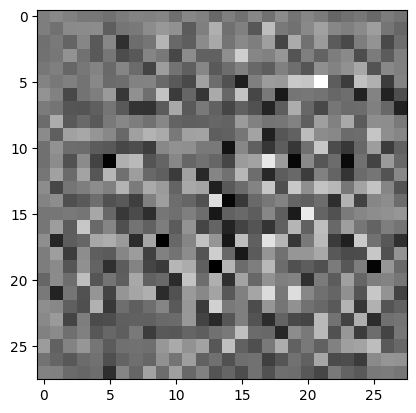

In [30]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## The Discriminator

In [31]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [32]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00244536]], shape=(1, 1), dtype=float32)


## Defining loss and optimizers

In [33]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

In [34]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss

In [35]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Saving Checkpoint

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [38]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [39]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [41]:
def generate_and_save_images(model, epoch, test_input):
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training the model

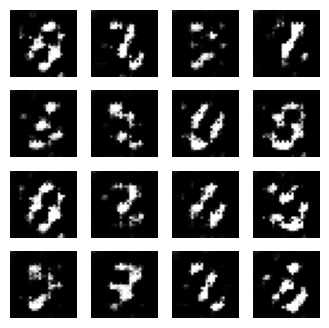

Time for epoch 4 is 457.0836317539215 sec


In [ ]:
train(image_train_dataset, EPOCHS)

In [ ]:
# Restore the latest checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# anim_file = 'dcgan.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#   filenames = glob.glob('image*.png')
#   filenames = sorted(filenames)
#   for filename in filenames:
#     image = imageio.imread(filename)
#     writer.append_data(image)
#   image = imageio.imread(filename)
#   writer.append_data(image)

In [ ]:
# ! pip install git+https://github.com/tensorflow/docs

In [ ]:
# import tensorflow_docs.vis.embed as embed
# embed.embed_file(anim_file)